# CNT Glyph Raytracing (SDF Ray Marching)

**What this is:** A compact, dependency‑light ray marcher that renders CNT‑style glyphs as **signed distance fields** (SDFs).  
**Why it’s useful:** Treats glyphs as geometry-first objects you can **compose, union, and animate**—great for visual tests of resonance, thickness, and symbol interactions.

### How to use
1. Run the **Core** cell to define primitives and glyphs.
2. Run **Preview Render** (fast, CPU‑only).
3. Use **Quality Presets** to switch to `preview`, `balanced`, or `studio` before re-rendering.
4. (Optional) Enable the **Multi‑Glyph Scene** section to place Anchor + Observer Ring + Benediction.

> Outputs are saved under the current working directory as PNGs. No GPU required. To scale up: increase resolution and steps, or port the SDF loop into CuPy/PyTorch for CUDA.

In [1]:
# === Core: SDF primitives, glyphs, camera, and ray marcher ===
import numpy as np, matplotlib.pyplot as plt

# ---------------- Camera & Render Defaults ----------------
RES={'W':128,'H':72}  # quick preview resolution
CAM={'eye':np.array([0.0,0.1,2.4]), 'look':np.array([0.0,0.0,0.0]), 'up':np.array([0.0,1.0,0.0]), 'fov':55.0}
SET={'steps':28,'far':6.0,'eps':1e-3,'gamma':2.2,'glow':0.4}
LIGHT = {'pos':np.array([2.0,2.2,1.4]), 'col':np.array([1.00,0.95,0.90])*1.6}
BG=np.array([0.03,0.03,0.04])

# --------------- Utilities ---------------
def norm(v): n=np.linalg.norm(v); return v/(n+1e-8)
def smin(a,b,k=0.18):
    h=np.clip(0.5+0.5*(b-a)/k,0,1); return (b*(1-h)+a*h)-k*h*(1-h)
def rotz(p,a):
    c,s=np.cos(a),np.sin(a); R=np.array([[c,-s,0],[s,c,0],[0,0,1]]); return p@R.T

# --------------- SDF Primitives ---------------
def sdf_sphere(p,r): return np.linalg.norm(p,axis=-1)-r
def sdf_torus(p,R=0.95,r=0.05):
    q=np.stack([np.linalg.norm(p[...,[0,2]],axis=-1)-R,p[...,1]],axis=-1)
    return np.linalg.norm(q,axis=-1)-r
def sdf_capsule(p,a,b,r):
    pa,ba=p-a,b-a; h=np.clip((pa*ba).sum(-1)/(ba*ba).sum(-1),0.0,1.0)
    return np.linalg.norm(pa-ba*h[...,None],axis=-1)-r
def sdf_box(p,b):
    q=np.abs(p)-b
    return np.minimum(np.maximum(q[...,0],np.maximum(q[...,1],q[...,2])),0.0)+np.linalg.norm(np.maximum(q,0.0),axis=-1)
def sdf_plane(p,h=0.9): return p[...,1]+h

# --------------- CNT Glyph(s) ---------------
def glyph_anchor(p):
    # Outer ring + vertical shaft + crossbar + inner node
    d=sdf_torus(p,0.95,0.05)
    d=smin(d,sdf_capsule(p,np.array([0,-0.52,0]),np.array([0,0.52,0]),0.055))
    d=smin(d,sdf_box(rotz(p,0)+np.array([0,-0.1,0]),np.array([0.4,0.05,0.06])))
    d=smin(d,sdf_sphere(p+np.array([0,0.25,0]),0.11))
    return d

# (Optional glyph placeholders you can fill in later)
def glyph_observer_ring(p):
    # Torus ring + three markers (simple version)
    d=sdf_torus(p,1.00,0.07)
    for k in range(3):
        ang=k*(2*np.pi/3); c=np.array([np.cos(ang),0.0,np.sin(ang)])
        d=smin(d, sdf_sphere(p-0.95*c, 0.09), 0.15)
    return d

def glyph_collapse_benediction(p):
    # Three stacked rings and a central conduit
    def roty(q,a):
        c,s=np.cos(a),np.sin(a)
        R=np.array([[ c,0,s],[0,1,0],[-s,0,c]]); return q@R.T
    p2=roty(p,0.35)
    d=sdf_torus(p2+np.array([0, 0.35,0]),0.65,0.06)
    d=smin(d,sdf_torus(p2+np.array([0, 0.00,0]),0.85,0.08),0.15)
    d=smin(d,sdf_torus(p2+np.array([0,-0.35,0]),1.05,0.10),0.15)
    d=smin(d,sdf_capsule(p,np.array([0,-0.8,0]),np.array([0,0.8,0]),0.05),0.12)
    return d

# --------------- Scene (switchable) ---------------
def scene_d(p, mode='anchor'):
    if mode=='anchor':
        return np.minimum(glyph_anchor(p), sdf_plane(p,0.9))
    elif mode=='multi':
        d = glyph_anchor(p)
        d = np.minimum(d, glyph_observer_ring(p - np.array([1.6,0.0,0.0])))
        # slight rotate-left on benediction
        def roty(q,a):
            c,s=np.cos(a),np.sin(a)
            R=np.array([[ c,0,s],[0,1,0],[-s,0,c]]); return q@R.T
        d = np.minimum(d, glyph_collapse_benediction(roty(p + np.array([1.6,0.0,0.0]), 0.45)))
        d = np.minimum(d, sdf_plane(p,0.9))
        return d
    else:
        return sdf_plane(p,0.9)

# --------------- Camera & March ---------------
def camera_rays(W,H,CAM):
    eye,look,up=CAM['eye'],CAM['look'],CAM['up']
    fov=np.deg2rad(CAM['fov']); aspect=W/H
    fwd=norm(look-eye); right=norm(np.cross(fwd,up)); upv=norm(np.cross(right,fwd))
    tan=np.tan(fov*0.5)
    xs=np.linspace(-tan*aspect,tan*aspect,W); ys=np.linspace(-tan,tan,H)
    xv,yv=np.meshgrid(xs,ys)
    dirs=(fwd[None,None,:]+xv[...,None]*right[None,None,:]+yv[...,None]*upv[None,None,:]).reshape(-1,3)
    dirs=dirs/(np.linalg.norm(dirs,axis=-1,keepdims=True)+1e-8)
    origins=np.repeat(eye[None,:],W*H,axis=0)
    return origins.reshape(H,W,3),dirs.reshape(H,W,3)

def ray_march(ro,rd,mode):
    t=0.0
    for _ in range(SET['steps']):
        d=scene_d(ro+rd*t,mode)
        if d<SET['eps']: return t,True
        t+=d
        if t>SET['far']: break
    return t,False

def surf_normal(p,mode,eps=1e-3):
    ex=np.array([eps,0,0]); ey=np.array([0,eps,0]); ez=np.array([0,0,eps])
    d0=scene_d(p,mode)
    n=np.stack([scene_d(p+ex,mode)-d0,scene_d(p+ey,mode)-d0,scene_d(p+ez,mode)-d0],axis=-1)
    return norm(n)

def render(mode='anchor', save_path=None):
    W,H=RES['W'],RES['H']
    orig,dirs=camera_rays(W,H,CAM)
    img=np.zeros((H,W,3),dtype=np.float32)
    for y in range(H):
        for x in range(W):
            ro,rd=orig[y,x],dirs[y,x]
            t,hit=ray_march(ro,rd,mode)
            if not hit: img[y,x]=BG; continue
            p=ro+rd*t; n=surf_normal(p,mode)
            # material: ground vs glyph heuristic
            is_ground=abs(scene_d(p,mode)-(p[1]+0.9))<1e-3
            alb=np.array([0.12,0.12,0.13]) if is_ground else np.array([0.85,0.82,1.0])
            ldir=norm(LIGHT['pos']-p); lam=max(np.dot(n,ldir),0.0)
            col=alb*lam*LIGHT['col']+alb*0.12
            # emissive halo near glyph distances
            gdist = glyph_anchor(p) if mode=='anchor' else min(glyph_anchor(p), glyph_observer_ring(p), glyph_collapse_benediction(p))
            halo=np.exp(-max(gdist,0)*6.0)*np.array([0.8,0.7,1.0])*0.15
            img[y,x]=np.clip(col+SET['glow']*halo,0,1)
    img=img**(1.0/SET['gamma'])
    plt.figure(figsize=(6,3.6)); plt.imshow(img); plt.axis('off'); plt.tight_layout()
    if save_path:
        plt.savefig(save_path,dpi=160,bbox_inches='tight',pad_inches=0.0)
    plt.show()
    return img
print("Core loaded. Ready to render.")

Core loaded. Ready to render.


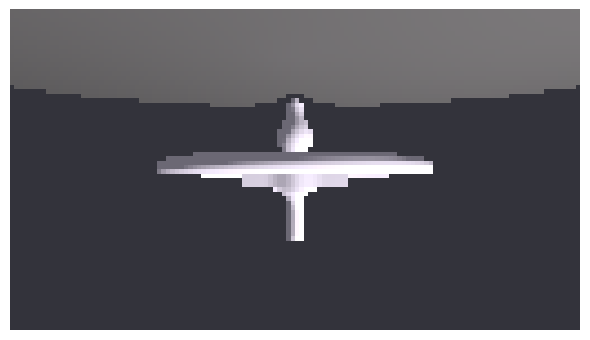

Saved: glyph_raytrace_preview.png


In [2]:
# === Preview Render (fast) ===
# Produces a quick image you can iterate with. Increase RES/steps later.
out = "glyph_raytrace_preview.png"
img = render(mode='anchor', save_path=out)
print("Saved:", out)

In [5]:
# === Quality Presets + Re-render Helper ===
def set_quality(preset="preview"):
    global RES, SET
    if preset=="preview":
        RES={'W':128,'H':72}; SET.update({'steps':28,'far':6.0})
    elif preset=="balanced":
        RES={'W':360,'H':202}; SET.update({'steps':60,'far':8.0})
    elif preset=="studio":
        RES={'W':720,'H':405}; SET.update({'steps':120,'far':12.0})
    else:
        raise ValueError("preset must be preview|balanced|studio")
    print("Quality:", preset, "| RES:", RES, "| steps:", SET['steps'])

# Example: set quality then render again
# set_quality("balanced")
# render(mode='anchor', save_path="glyph_raytrace_balanced.png")

In [6]:
# === Optional Multi-Glyph Scene ===
# Uncomment the lines below to render Anchor + Observer Ring + Benediction together.
# set_quality("balanced")  # or "studio" if you're patient
# render(mode='multi', save_path="glyph_raytrace_multi.png")